# KTR Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from orbit.models.ktrlite import KTRLiteMAP
from orbit.models.ktrx import KTRXAggregated

from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.metrics import smape

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
DATA_FILE = "./data/iclaims_example.csv"
date_col = 'week'
response_col = 'claims'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

In [30]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.38660,0.16888,-0.32831,0.11303
1,2010-01-10,13.62422,0.16888,-0.20470,0.16433
2,2010-01-17,13.39874,0.18514,-0.30233,0.11303
3,2010-01-24,13.13755,0.15235,-0.20470,0.10245
4,2010-01-31,13.19676,0.08335,-0.25232,0.07002


### Train / Test Split

In [6]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLiteMAP

In [90]:
ktr_stan = KTRLiteMAP(
    response_col='claims',
    date_col='week',
    # seasonality
    #seasonality=52,
   # seasonality_fs_order=5,
    level_knot_scale=.5,
    span_level=.1,
    span_coefficients=.3,
    rho_coefficients=.15,
    estimator_type=StanEstimatorMAP,
)

In [91]:
ktr_stan.fit(train_df)

In [94]:
def sandwich_kernel(x, x_i):
    """
    x: points required to compute kernel weight
    x_i: reference points location used to compute correspondent distance of each entry points
    rho: smoothing parameter known as "length-scale" in gaussian process
    alpha: marginal standard deviation parameter in gaussian process; one should ignore in kernel regression (keep it = 1.0)
    b[deprecated]: radius or sometime named as (2*rho) that controls strength of covariance; the smaller the shorter raidus (dist. to negihbour)
    will take into effect
    return:
        a matrix with N x M such that
        N as the number of entry points
        M as the number of reference points
        matrix entries hold the value of weight of each element
    see also:
      1. https://mc-stan.org/docs/2_24/stan-users-guide/gaussian-process-regression.html
      2. https://en.wikipedia.org/wiki/Local_regression
    """
    N = len(x)
    M = len(x_i)
    k = np.zeros((N, M), dtype=np.double)

    np_idx = np.where(x < x_i[0])
    k[np_idx, 0] = 1

    for m in range(M - 1):
        np_idx = np.where(np.logical_and(x >= x_i[m], x < x_i[m + 1]))
        total_dist = x_i[m + 1] - x_i[m]
        backward_dist = x[np_idx] - x_i[m]
        forward_dist = x_i[m + 1] - x[np_idx]
        k[np_idx, m] = forward_dist / total_dist
        k[np_idx, m + 1] = backward_dist / total_dist

    np_idx = np.where(x >= x_i[M - 1])
    k[np_idx, M - 1] = 1

    # TODO: it is probably not needed
    k = k / np.sum(k, axis=1, keepdims=True)

    return k

In [97]:
sandwich_kernel(np.array([0.2,0.4]), np.array([0.3,0.5]))

array([[1. , 0. ],
       [0.5, 0.5]])

In [93]:
predicted_df = ktr_stan.predict(test_df, decompose=True)
predicted_df.head()

[1.00255754 1.00511509 1.00767263 1.01023018 1.01278772 1.01534527
 1.01790281 1.02046036 1.0230179  1.02557545 1.02813299 1.03069054
 1.03324808 1.03580563 1.03836317 1.04092072 1.04347826 1.04603581
 1.04859335 1.0511509  1.05370844 1.05626598 1.05882353 1.06138107
 1.06393862 1.06649616 1.06905371 1.07161125 1.0741688  1.07672634
 1.07928389 1.08184143 1.08439898 1.08695652 1.08951407 1.09207161
 1.09462916 1.0971867  1.09974425 1.10230179 1.10485934 1.10741688
 1.10997442 1.11253197 1.11508951 1.11764706 1.1202046  1.12276215
 1.12531969 1.12787724 1.13043478 1.13299233]
[0.05370844 0.15601023 0.25831202 0.36061381 0.4629156  0.56521739
 0.66751918 0.76982097 0.87212276 0.97442455]
(1, 52)
[[12.38557094 12.38557094 12.38557094 12.38557094 12.38557094 12.38557094
  12.38557094 12.38557094 12.38557094 12.38557094 12.38557094 12.38557094
  12.38557094 12.38557094 12.38557094 12.38557094 12.38557094 12.38557094
  12.38557094 12.38557094 12.38557094 12.38557094 12.38557094 12.38557094
 

,week,prediction,trend
0,2017-07-02,12.38557,12.38557
1,2017-07-09,12.38557,12.38557
2,2017-07-16,12.38557,12.38557
3,2017-07-23,12.38557,12.38557
4,2017-07-30,12.38557,12.38557


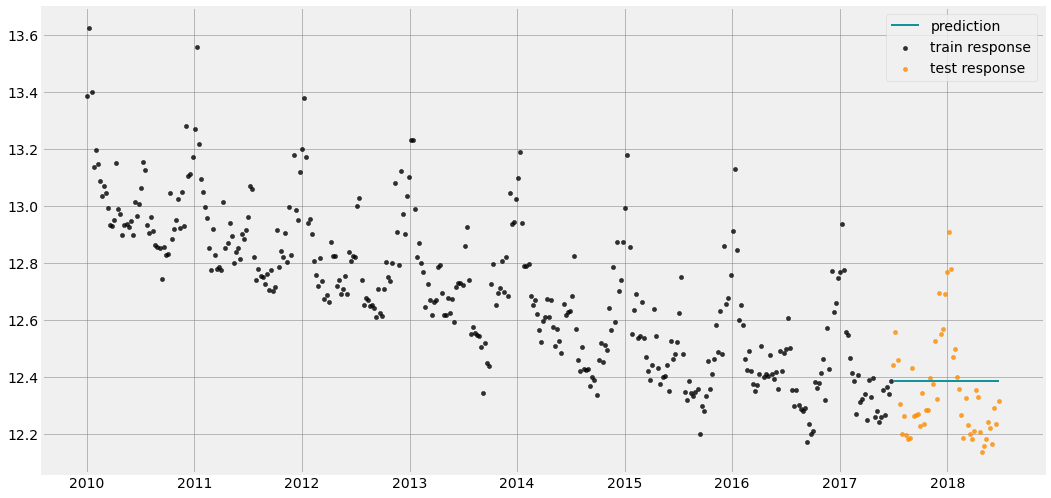

In [86]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

## KTRXAggregated

In [58]:
level_knot_dates = ktr_stan._level_knot_dates
level_knots = ktr_stan._aggregate_posteriors['map']['lev_knot'][0]
seasonal_knots_input = {
    '_seas_coef_knot_dates': ktr_stan._coef_knot_dates,
    '_sea_coef_knot': ktr_stan._aggregate_posteriors['map']['coef_knot'],
    '_sea_rho': ktr_stan.rho_coefficients,
    '_seasonality': ktr_stan._seasonality,
    '_seasonality_fs_order': ktr_stan._seasonality_fs_order,
} 

In [65]:
ktr_pyro = KTRXAggregated(
    response_col='claims',
    date_col='week',
    #regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    level_knot_dates=level_knot_dates,
    level_knots=level_knots,
    seasonal_knots_input=seasonal_knots_input,
    level_knot_scale=.1, #.01
    span_coefficients=0.3,
    rho_coefficients=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    #learning_rate_total_decay=0.05,
    verbose=False,
    message=100,
    aggregate_method="median",
    estimator_type=PyroEstimatorVI,
)

In [66]:
ktr_pyro.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


In [67]:
predicted_df = ktr_pyro.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality_input,regression
0,2017-07-02,12.39230,12.36594,0.02636,0.00000
1,2017-07-09,12.38437,12.36594,0.01843,0.00000
2,2017-07-16,12.36372,12.36594,-0.00222,0.00000
3,2017-07-23,12.33253,12.36594,-0.03341,0.00000
4,2017-07-30,12.29433,12.36594,-0.07161,0.00000


In [68]:
predicted_df.trend

0    12.36594
1    12.36594
2    12.36594
3    12.36594
4    12.36594
5    12.36594
6    12.36594
7    12.36594
8    12.36594
9    12.36594
10   12.36594
11   12.36594
12   12.36594
13   12.36594
14   12.36594
15   12.36594
16   12.36594
17   12.36594
18   12.36594
19   12.36594
20   12.36594
21   12.36594
22   12.36594
23   12.36594
24   12.36594
25   12.36594
26   12.36594
27   12.36594
28   12.36594
29   12.36594
30   12.36594
31   12.36594
32   12.36594
33   12.36594
34   12.36594
35   12.36594
36   12.36594
37   12.36594
38   12.36594
39   12.36594
40   12.36594
41   12.36594
42   12.36594
43   12.36594
44   12.36594
45   12.36594
46   12.36594
47   12.36594
48   12.36594
49   12.36594
50   12.36594
51   12.36594
Name: trend, dtype: float64

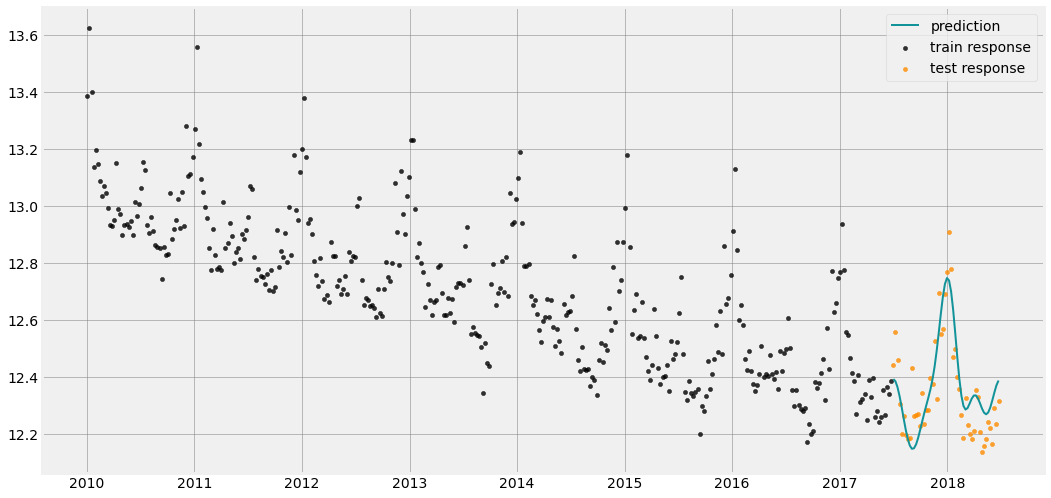

In [69]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col='week', actual_col='claims', 
                    test_actual_df=test_df)

## hyper-parameter tuning [TO Check]

In [37]:
from orbit.diagnostics.backtest import grid_search_orbit
from orbit.diagnostics.metrics import smape, mape, wmape

In [38]:
# param_grid = {'num_steps': [100, 1000]}

param_grid = {'span_level': [0.1, 0.2], 'span_coefficients': [0.2, 0.3],
              'rho_level': [0.05, 0.1], 'rho_coefficients': [0.15, 0.2]}

In [40]:
best_params, tuned_df = grid_search_orbit(param_grid, 
                                        model=ktr_map, 
                                        df=df,
                                        min_train_len=100, incremental_len=100, forecast_len=20, 
                                        metrics=None, criteria=None, verbose=True)

  0%|          | 0/16 [00:00<?, ?it/s]

tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.1}


  6%|▋         | 1/16 [00:15<03:48, 15.21s/it]

tuning metric:0.065393
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.2}


 12%|█▎        | 2/16 [00:30<03:33, 15.26s/it]

tuning metric:0.012355
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.1}


 19%|█▉        | 3/16 [00:45<03:18, 15.30s/it]

tuning metric:0.090586
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.2}


 25%|██▌       | 4/16 [01:00<03:00, 15.05s/it]

tuning metric:0.081442
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.1}


 31%|███▏      | 5/16 [01:14<02:43, 14.89s/it]

tuning metric:0.068079
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.2}


 38%|███▊      | 6/16 [01:29<02:28, 14.84s/it]

tuning metric:0.15421
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.1}


 44%|████▍     | 7/16 [01:44<02:13, 14.85s/it]

tuning metric:0.012057
tuning hyper-params {'rho_coefficients': 0.15, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.2}


 50%|█████     | 8/16 [01:59<01:58, 14.75s/it]

tuning metric:0.16231
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.1}


 56%|█████▋    | 9/16 [02:13<01:42, 14.70s/it]

tuning metric:0.068675
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.2, 'span_level': 0.2}


 62%|██████▎   | 10/16 [02:28<01:28, 14.68s/it]

tuning metric:0.15767
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.1}


 69%|██████▉   | 11/16 [02:42<01:13, 14.62s/it]

tuning metric:0.072529
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.05, 'span_coefficients': 0.3, 'span_level': 0.2}


 75%|███████▌  | 12/16 [02:57<00:58, 14.59s/it]

tuning metric:0.085704
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.1}


 81%|████████▏ | 13/16 [03:11<00:43, 14.56s/it]

tuning metric:0.086096
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.2, 'span_level': 0.2}


 88%|████████▊ | 14/16 [03:26<00:29, 14.62s/it]

tuning metric:0.13729
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.1}


 94%|█████████▍| 15/16 [03:41<00:14, 14.62s/it]

tuning metric:0.08159
tuning hyper-params {'rho_coefficients': 0.2, 'rho_level': 0.1, 'span_coefficients': 0.3, 'span_level': 0.2}


100%|██████████| 16/16 [03:55<00:00, 14.74s/it]

tuning metric:0.1716


In [43]:
tuned_df.head()

,rho_coefficients,rho_level,span_coefficients,span_level,metrics
0,0.15000,0.05000,0.20000,0.10000,0.06539
1,0.15000,0.05000,0.20000,0.20000,0.01235
2,0.15000,0.05000,0.30000,0.10000,0.09059
3,0.15000,0.05000,0.30000,0.20000,0.08144
4,0.15000,0.10000,0.20000,0.10000,0.06808


In [42]:
best_params

[{'rho_coefficients': 0.15,
  'rho_level': 0.1,
  'span_coefficients': 0.3,
  'span_level': 0.1}]